# Neutron burst calculation
The following is a notebook that can compute the final abundances of a network of species connected only via neutron burst reactions. The mathematics is provided in Davila & Meyer.

The neutron burst is a type of explosive nucleosynthesis that occurs in the bottom of the helium shell. It is triggered when the shock heats the material increasing the rate of the $^{22}$Ne($\alpha$,n)$^{25}$Mg reaction and thus causing a sharp, but breif spike in the neutron density. 

Now, the neutron burst is essentially an acyclic, linear network and thus a graph theory approach can be invoked in which the abundance of species $j$ that flows to species $i$ across some path $P$ is given by:
\begin{gather}
G_{ij}^{P}(\tau) = F^{P} \frac{(\alpha \tau)^{N-1}}{(N-1)!} \exp\Big(\sum_{k=1}^\infty x_k \frac{(-\tau)^k}{k!}\Big)
\end{gather}

This result is exact, but written in terms of an infinite sum. For low $\tau$, higher order terms in the sum can be ignored due to the factorial in the denominator, but for high $\tau$ more creative approaches are needed. 

Using this result, given the acyclic nature of the network the abundance of species $i$ at exposure $\tau$ is given along a specific path by:
\begin{gather}
Y_i^P(\tau) = \sum_{j\leq i} G_{ij}^{P}(\tau)
\end{gather}
and the final abundance of $i$ along all paths is simply the sum of all paths. 

## A simple case 
Let's consider the simplest case possible: one path with identical cross sections along the path. In this case the $G_{ij}$s become:
\begin{gather}
G_{ij}(\tau) = \frac{(\alpha \tau)^{N-1}}{(N-1)!} \exp(-\alpha \tau)
\end{gather}

Let's consider the reaction chain:
\begin{gather}
1 + n \rightarrow 2 + \gamma\notag\\
2 + n \rightarrow 3 + \gamma\notag\\
3 + n \rightarrow 4 + \gamma\notag
\end{gather}

where 1, 2, 3, and 4 are arbitrary species and 'n' represents neutrons. From above, the abundance of the final species, 4, can be written as:
\begin{gather}
Y_i(\tau) = \sum_{j\leq i} G_{ij}(\tau) = G_{14}(\tau) + G_{24}(\tau) + G_{34}(\tau) + G_{44}(\tau)
\end{gather}


To solve this network exactly we have the coupled differential equations:
\begin{gather}
\frac{dY_1}{dt} = -\sigma_{n,1} Y_1\\
\frac{dY_2}{dt} = \sigma_{n,1} Y_1 - \sigma_{n,2}Y_2\\
\frac{dY_3}{dt} = \sigma_{n,2} Y_2 - \sigma_{n,3}Y_3\\
\frac{dY_4}{dt} = \sigma_{n,3} Y_3 - \sigma_{n,4}Y_4
\end{gather}
where the $\sigma_n$ are the neutron capture rates for each species. 


To model this we begin by importing the necessary libraries, including wnpoly which is used to obtain the complete homogeneous symmetric polynomials from the reaction rates and bell polynomials:

In [22]:
import sys
!{sys.executable} -m pip install --quiet wnpoly
from gslconsts.consts import *
from scipy.integrate import solve_ivp
import numpy as np
import math
import wnpoly as wp
from scipy.stats import gmean
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Next, using the gslconsts package we will define some constants that will be important throughout:

In [23]:
k = GSL_CONST_CGS_BOLTZMANN
N_A = GSL_CONST_NUM_AVOGADRO
m_n = GSL_CONST_CGS_MASS_NEUTRON

Now, we define two functions. One to solve the system of differential equations to solve the network and one to get the solution using the $G_{ij}$s:

In [24]:
def Y(t, y, sigs):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigs[0]*y[0]
    for i in range(1, N):
        result[i] = sigs[i-1]*y[i-1] - sigs[i]*y[i]
    return result

def g(tau, m_new, x, h, alpha):
    result = 0 
    for i in range(len(h)):
        result += x[i] * (-tau)**i / math.factorial(i)
    return (alpha*tau)**(m-1) * np.exp(result) / math.factorial(m-1)

Now we lay out the general approach for analytically solving the neutron burst in the framework of this simple problem. First, we define the parameters such as the initial composition of the material and the neutron capture cross sections. For this example all of the material will start as species '1' and each will have the same reaction rate:

In [25]:
neutron_capture_rate = np.ones(4) 
ys = np.zeros(4)
ys[0] = 1
m = len(ys)

Now, we compute the symmetric polynomials to get the coefficients 'x' of the Bell Polynomials. For this simple example the only nonzero x will $x_1$. This is the major simplification that was made when assuming all cross sections were equal. 

In [26]:
s = wp.symm.Complete()
h = s.compute_normalized(neutron_capture_rate, len(neutron_capture_rate))

bell = wp.bell.Bell()
x = bell.invert(h)
print(x)

[0. 1. 0. 0. 0.]


Finally, we compute the geometric mean of the reaction rates and solve for the abundances:

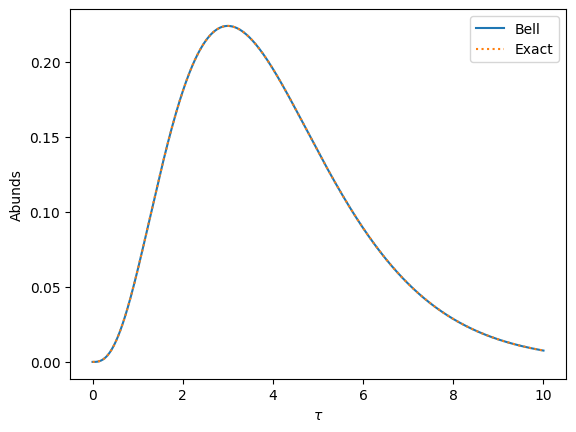

In [27]:
alpha = gmean(neutron_capture_rate[0:len(neutron_capture_rate)-1])

tau = np.linspace(0,10,1000)

plt.plot(tau, g(tau, m, x, h, alpha), label='Bell')

#solve the network 
sol = solve_ivp(Y, [0, tau[len(tau)-1]], ys, args=(neutron_capture_rate,), max_step=0.002)
plt.plot(sol.t, sol.y[m-1], ':', label='Exact')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel('Abunds')
plt.show()

Since our simplification gives us an exact answer rather than an infinite sum in the exponential, our result is exact. Now, let's turn our attention to a realistic case.

## Realistic Model

Let's consider the nuclear network:

\begin{gather}
^{40}Ca + n \rightarrow ^{41}Ca + \gamma\\
^{41}Ca + n \rightarrow ^{42}Ca + \gamma\\
^{42}Ca + n \rightarrow ^{43}Ca + \gamma\\
^{43}Ca + n \rightarrow ^{44}Ca + \gamma
\end{gather}

Our network is then:
\begin{gather}
\frac{dY(^{40}Ca)}{dt} = -\sigma_{n, 40} Y(^{40}Ca)\\
\frac{dY(^{41}Ca)}{dt} = \sigma_{n,40} Y(^{40}Ca) - \sigma_{n,41}Y(^{41}Ca)\\
\frac{dY(^{42}Ca)}{dt} = \sigma_{n,41} Y(^{41}Ca) - \sigma_{n,42}Y(^{42}Ca)\\
\frac{dY(^{43}Ca)}{dt} = \sigma_{n,42} Y(^{42}Ca) - \sigma_{n,43}Y(^{43}Ca)\\
\frac{dY(^{44}Ca)}{dt} = \sigma_{n,43} Y(^{43}Ca) - \sigma_{n,44}Y(^{44}Ca)
\end{gather}

### Computing neutron capture cross sections

The first step to a realistic model is to obtain the neutron capture cross sections for each reaction, which can be done using wnnet. We begin by downloading the necessary libraries and importing the network data. 

In [28]:
import os, io, requests
from lxml import etree 

!{sys.executable} -m pip install --quiet wnnet
import wnnet as wn

net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Now we can define a temperature in $10^9$K and use wnnet to obtain the neutron capture reaction rate:

In [37]:
t9 = 3

induced_nuc_xpath = "[z = 20 and a - z >= 20 and a - z <=24]"
induced_reac_xpath = "[reactant = 'n']"

reacs = net.compute_rates(t9, nuc_xpath=induced_nuc_xpath, reac_xpath = induced_reac_xpath)
for key, values in list(reacs.items()):
    print('reaction :', key, ';', 'Forward rate :', '{:.2e}'.format(values[0]), ';', 'Reverse rate :', '{:.2e}'.format(values[1]))

Now, the reaction rate is given by:
\begin{gather}
r(T) = N_A<\sigma v>
\end{gather}

then, to obtain the cross section (in millibarns) we obtain the thermal velocity and divide the reaction rate by it along with Avagadro's number:

In [39]:
T = t9 * 10**9
v_T = np.sqrt((2*k*T)/(m_n/wn.consts.u * N_A))

sigs = []
for key, value in list(reacs.items()):
    sigs.append(value[0]/(v_T * wn.const.N_A))

### Obtaining an initial approximation

Now, following the same procedure as before we can obtain the solutions:

In [40]:
neutron_capture_rates = sigs[0:len(neutron_rates)-1]
ys = np.zeros(len(neutron_capture_rates))
ys[0] = 1
m = len(ys)

s = wp.symm.Complete()
h = s.compute_normalized(neutron_capture_rate, len(neutron_capture_rate))

bell = wp.bell.Bell()
x = bell.invert(h)
print(x)

alpha = gmean(neutron_capture_rate[0:len(neutron_capture_rate)-1])

tau = np.linspace(0,10,1000)

plt.plot(tau, g(tau, m, x, h, alpha), label='Bell')

#solve the network 
sol = solve_ivp(Y, [0, tau[len(tau)-1]], ys, args=(neutron_capture_rate,), max_step=0.002)
plt.plot(sol.t, sol.y[m-1], ':', label='Exact')
plt.legend()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0